In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# get a list of columm names and types for each table
inspector = inspect(engine)

columns_sta = inspector.get_columns('Station')
for cs in columns_sta:
    print(cs['name'], cs["type"])
    
print("--------------")
columns_meas = inspector.get_columns('Measurement')
for cm in columns_meas:
    print(cm['name'], cm["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
--------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement).order_by(Measurement.date.desc()).first()
print(recent_date.date)

2017-08-23


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
date_desc = session.query(Measurement).order_by(Measurement.date.desc()).all()
    
# Calculate the date one year from the last date in data set (performed a for loop to inspect the data).
last_year = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_scores = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= last_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
date_list = []
prcp_list = []
for p in precip_scores:
    date_list.append(p[0])
    prcp_list.append(p[1])
    data = {'Date': date_list, 'Precipitation': prcp_list}
    precip_df = pd.DataFrame(data = data)

# Sort the dataframe by date
precip_df.sort_values(by = 'Date', ascending = True)
precip_df.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


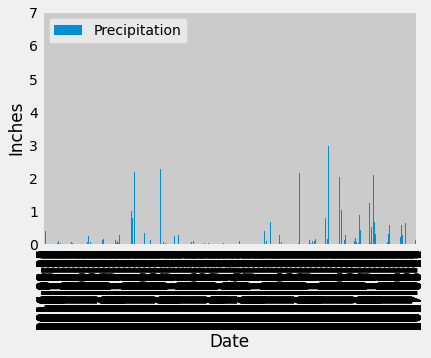

<Figure size 432x288 with 0 Axes>

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_plot = precip_df.plot(kind = "bar", grid = True, xlabel = "Date", ylabel = "Inches")
prcp_plot.set_xticklabels(precip_df["Date"], rotation=90)

plt.show()
plt.tight_layout()

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation date
precip_stats = pd.DataFrame(columns = ["precipitation"], index = ["count", "mean", "std", "min", "25%", "50%", "75%", "max"])
precip_stats.loc["count"] = pd.Series({"precipitation": precip_df["Precipitation"].count()})

quartiles = precip_df["Precipitation"].quantile([.25,.5,.75])

precip_stats.loc["mean"] = pd.Series({"precipitation": precip_df["Precipitation"].mean()})
precip_stats.loc["std"] = pd.Series({"precipitation": precip_df["Precipitation"].std()})
precip_stats.loc["min"] = pd.Series({"precipitation": precip_df["Precipitation"].min()})
precip_stats.loc["25%"] = pd.Series({"precipitation": quartiles[0.25]})
precip_stats.loc["50%"] = pd.Series({"precipitation": quartiles[0.5]})
precip_stats.loc["75%"] = pd.Series({"precipitation": quartiles[0.75]})
precip_stats.loc["max"] = pd.Series({"precipitation": precip_df["Precipitation"].max()})
precip_stats

,precipitation
count,2021
mean,0.177279
std,0.46119
min,0.0
25%,0.0
50%,0.02
75%,0.13
max,6.7


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number of stations in the dataset
station_number = session.query(Station).count()
print(station_number)

9


In [22]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc())
for a in active_stations:
    print(a)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temps = session.query(Measurement).filter(Measurement.station == "USC00519281").all()
temps_list = []
for t in temps:
    temps_list.append(t.tobs)

from statistics import mean
print(f"The lowest temperature is {min(temps_list)}")
print(f"The highest temperature is {max(temps_list)}")
print(f"The average temperature is {mean(temps_list)}")

The lowest temperature is 54.0
The highest temperature is 85.0
The average temperature is 71.66378066378067


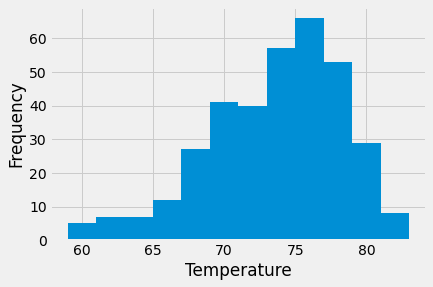

In [12]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps_one_year = session.query(Measurement).\
                filter(Measurement.station == "USC00519281").\
                filter(Measurement.date >= last_year).all()

temps_one_year_list = []
for t_one in temps_one_year:
    temps_one_year_list.append(t_one.tobs)
    
plt.hist(temps_one_year_list, bins = 12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [25]:
# Close Session
session.close()